In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime
bond_data = pd.read_csv("bond_close_selected_dirty.csv")
# Convert dates to datetime objects for calculation
bond_data['Issue Date'] = pd.to_datetime(bond_data['Issue Date'])
bond_data['Maturity Date'] = pd.to_datetime(bond_data['Maturity Date'])
bond_data['Years to Maturity'] = bond_data['Maturity Date'].apply(lambda x: (x - datetime(2024, 1, 8) ).days / 365.25)


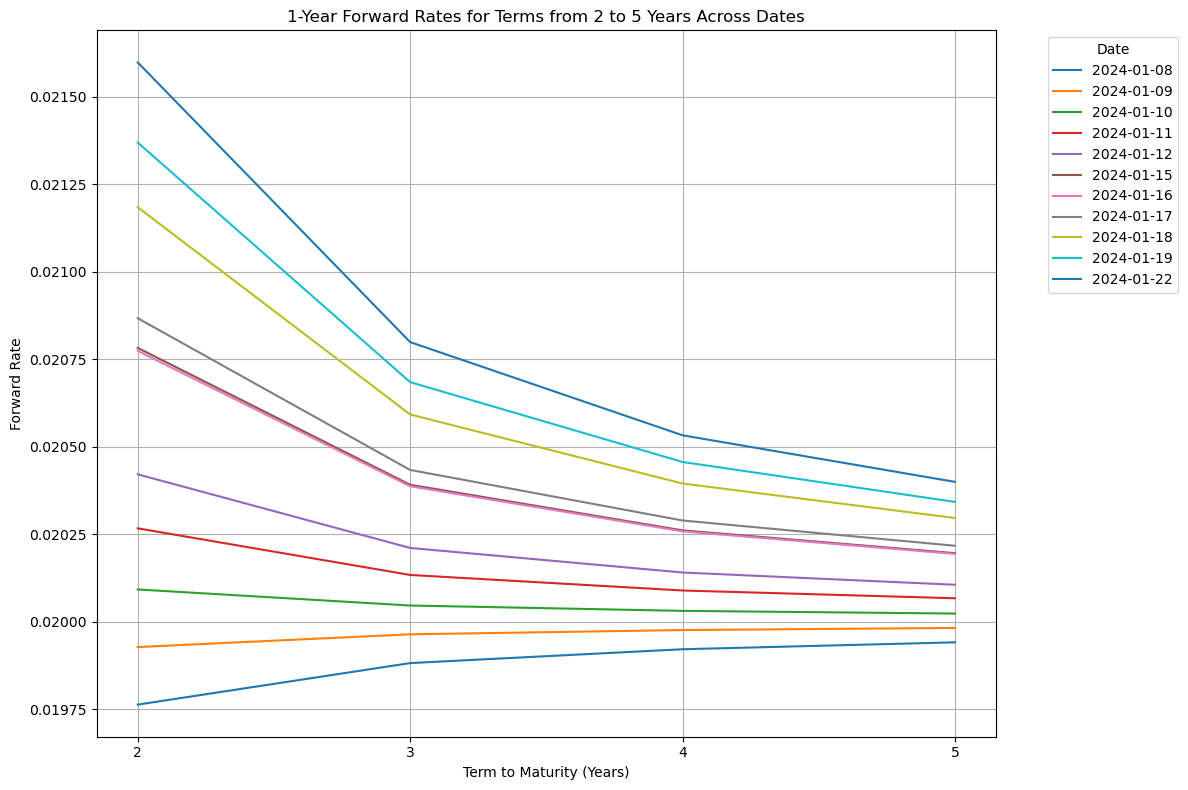

In [9]:
# Placeholder for storing forward rates for each date
forward_rates_by_date = {}
dates = bond_data.columns[4:-1]
# Iterate over each date to calculate spot rates and forward rates
def present_value_revised(cash_flows, spot_rates, years_to_maturity):
    discount_factors = np.array([1 / (1 + spot_rates[min(i, len(spot_rates)-1)])**years_to_maturity[i] for i in range(len(cash_flows))])
    return np.sum(cash_flows * discount_factors)

def calculate_forward_rate_from_spots(spot_rate_t, spot_rate_tn, t, tn):
    """
    Calculate the forward rate from time t to tn using spot rates.
    """
    forward_rate = ((1 + spot_rate_tn)**tn / (1 + spot_rate_t)**t)**(1/(tn-t)) - 1
    return forward_rate

for date in dates:
    # Organize bond data for the current date
    bonds_data_current_date = bond_data[['Coupon', 'Years to Maturity', date]].copy()
    bonds_data_current_date.rename(columns={date: 'Dirty Price'}, inplace=True)

    # Recalculate spot rates with the revised method for the current date
    def bootstrap_yield_curve_for_date(bonds_data):
        spot_rates = []  # Initialize list to store spot rates for dynamic appending
        for _, bond in bonds_data.iterrows():
            cash_flows = np.array([bond['Coupon']] * int(bond['Years to Maturity']) + [100 + bond['Coupon']])
            price = bond['Dirty Price']  # Dirty price of the bond for the current date
            years_to_maturity = np.arange(1, len(cash_flows) + 1)
            
            def objective_revised_for_date(spot_rate):
                all_spot_rates = np.append(spot_rates, spot_rate)
                pv = present_value_revised(cash_flows, all_spot_rates, years_to_maturity)
                return (pv - price)**2
            
            bounds = [(0, 0.15)]  # Spot rate bounds
            result = minimize(objective_revised_for_date, [0.02], bounds=bounds, method='L-BFGS-B')
            spot_rates.append(result.x[0])
        
        return np.array(spot_rates)

    spot_rates_for_date = bootstrap_yield_curve_for_date(bonds_data_current_date.sort_values(by='Years to Maturity'))

    # Calculate 1-year forward rates for the current date
    forward_rates_for_date = []
    for tn in range(2, 6):
        forward_rate = calculate_forward_rate_from_spots(spot_rates_for_date[0], spot_rates_for_date[tn-1], 1, tn)
        forward_rates_for_date.append(forward_rate)
    
    # Store the forward rates for the current date
    forward_rates_by_date[date] = forward_rates_for_date

# Now plot the 1-year forward curves for each date
plt.figure(figsize=(12, 8))
for date, forward_rates in forward_rates_by_date.items():
    plt.plot(range(2, 6), forward_rates, label=date)

plt.title('1-Year Forward Rates for Terms from 2 to 5 Years Across Dates')
plt.xlabel('Term to Maturity (Years)')
plt.ylabel('Forward Rate')
plt.xticks(range(2, 6))
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
forward_rates_by_date

{'2024-01-08': [0.019762746057471414,
  0.01988136612971858,
  0.019920909219951488,
  0.019940681340004485],
 '2024-01-09': [0.01992722390734869,
  0.01996361130458757,
  0.01997574072548125,
  0.019981805490019156],
 '2024-01-10': [0.02009169853347581,
  0.020045848236316166,
  0.02003056526189928,
  0.02002292386055826],
 '2024-01-11': [0.020266346724765016,
  0.020133164669819292,
  0.02008877451497737,
  0.020066580161910652],
 '2024-01-12': [0.02042064525577736,
  0.02021030094823728,
  0.02014019581489923,
  0.02010514505476446],
 '2024-01-15': [0.02078179023595217,
  0.02039082024519967,
  0.02026053019457108,
  0.02019539140799087],
 '2024-01-16': [0.020773287787572814,
  0.020386570640423818,
  0.020257697484498793,
  0.020193267010340632],
 '2024-01-17': [0.02086653595090393,
  0.020433175994353014,
  0.0202887635598481,
  0.02021656500678337],
 '2024-01-18': [0.0211836354591477,
  0.02059164613881226,
  0.020394392637754777,
  0.020295780184152568],
 '2024-01-19': [0.021368

In [12]:
forward_rates = pd.DataFrame(forward_rates_by_date).T
forward_rates.columns = ['1yr-1yr', '1yr-2yr', '1yr-3yr', '1yr-4yr']

# Calculate daily log-returns of forward rates
log_returns_forward = np.log(forward_rates / forward_rates.shift(1)).dropna()

# Calculate the covariance matrix for forward rate log-returns
cov_matrix_forward = log_returns_forward.cov()

# Calculate eigenvalues and eigenvectors
eigenvalues_forward, eigenvectors_forward = np.linalg.eig(cov_matrix_forward)

# Print the first eigenvalue and its associated eigenvector
print(f"First Eigenvalue: {eigenvalues_forward[0]}")
print(f"Associated Eigenvector: {eigenvectors_forward[:,0]}")
print(cov_matrix_forward)

First Eigenvalue: 3.606280081391745e-05
Associated Eigenvector: [-0.83195001 -0.4247796  -0.28520183 -0.21466575]
          1yr-1yr   1yr-2yr   1yr-3yr   1yr-4yr
1yr-1yr  0.000025  0.000013  0.000009  0.000006
1yr-2yr  0.000013  0.000007  0.000004  0.000003
1yr-3yr  0.000009  0.000004  0.000003  0.000002
1yr-4yr  0.000006  0.000003  0.000002  0.000002
